In [38]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector

## Loading dataset

In [20]:
wines = pd.read_csv('Q3_winequalityN.csv')
wines

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [21]:
wines['type'].unique()

array(['white', 'red'], dtype=object)

In [22]:
wines['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9], dtype=int64)

In [23]:
wines.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [24]:
wines.dropna(inplace=True)
wines.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [25]:
wines.type.replace(('red', 'white'), (1, 0), inplace=True)

## Sequential Forward Selection

In [8]:
X = wines.drop('type', axis=1)
y = wines['type']

scaler = StandardScaler()
x_normal = scaler.fit_transform(X)
df = pd.DataFrame(x_normal, columns=X.columns.tolist())

x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=42)

In [9]:
def fit_model(x_train, x_test, y_train, y_test, subset, model):
#     print(x_train)
    model.fit(x_train[subset].values, y_train.values)
    y_pred = model.predict(x_test[subset].values)
    return accuracy_score(y_test.values, y_pred)


def sffs(x_train, x_test, y_train, y_test, model, k_features):
    
#     num_features = x_train.shape[1]
    all_features = x_train.columns.tolist()
    best_scores = []
    best_subset = []
    
    init_time = time.time()
    while (len(best_subset) < k_features):
        scores = []
        subsets = []
        all_features = list(set(all_features) - set(best_subset))
        for feature in all_features:
            subset = best_subset + [feature]
#             print(subset)
            score = fit_model(x_train, x_test, y_train, y_test, subset, model)
            scores.append(score)
            subsets.append(subset)

        best_score_index = np.argmax(scores)
        best_scores.append(scores[best_score_index])
        best_subset = subsets[best_score_index]
    
    print("SFFS time:",  
      (time.time() - init_time)*1000, 
      "miliseconds\n")
    return (best_scores, best_subset)

In [10]:
knn = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='manhattan', algorithm='ball_tree')

score, subset = sffs(x_train, x_test, y_train, y_test, knn, len(x_train.columns.tolist()))
print("Selected features in order: \n", subset)
print("\nSelected features accuracy score: \n", score)

SFFS time: 2534.674882888794 miliseconds

Selected features in order: 
 ['total sulfur dioxide', 'chlorides', 'density', 'sulphates', 'alcohol', 'residual sugar', 'citric acid', 'quality', 'fixed acidity', 'volatile acidity', 'free sulfur dioxide', 'pH']

Selected features accuracy score: 
 [0.9053217821782178, 0.9746287128712872, 0.9820544554455446, 0.9931930693069307, 0.9938118811881188, 0.9956683168316832, 0.9938118811881188, 0.9956683168316832, 0.9956683168316832, 0.9931930693069307, 0.9938118811881188, 0.9907178217821783]


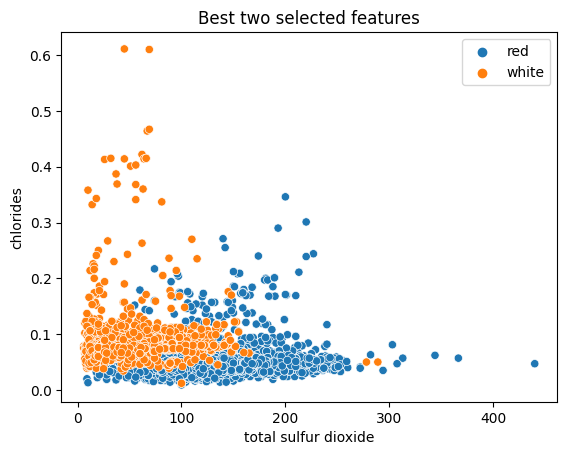

In [11]:
ax = sns.scatterplot(x=subset[0], y=subset[1], data=wines, hue='type');
ax.set_title('Best two selected features');
handles, labels  =  ax.get_legend_handles_labels()

ax.legend(handles, ['red', 'white'], loc='upper right');

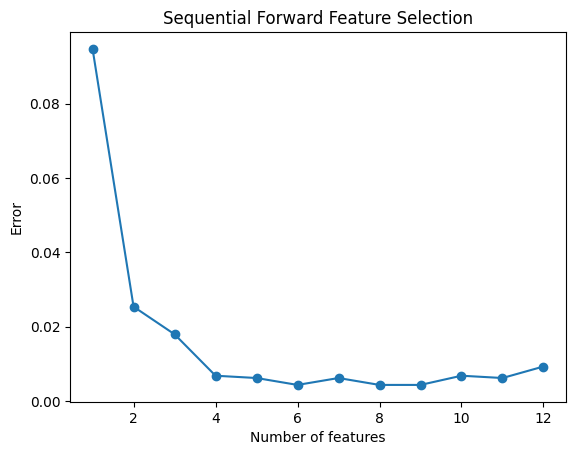

In [18]:
plt.plot(list(range(1,len(x_train.columns.tolist())+1)), 1 - np.array(score), marker='o');
plt.ylabel('Error')
plt.xlabel('Number of features')
plt.title('Sequential Forward Feature Selection');

In [39]:
feature_names = np.array(list(wines.columns)[1:])
estimator = SVC(kernel="linear")
tic_fwd = time.time()
sfs_forward = SequentialFeatureSelector(
    estimator, n_features_to_select=2, direction="forward"
).fit(x_train, y_train)
toc_fwd = time.time()

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")

Features selected by forward sequential selection: ['total sulfur dioxide' 'density']
Done in 9.169s


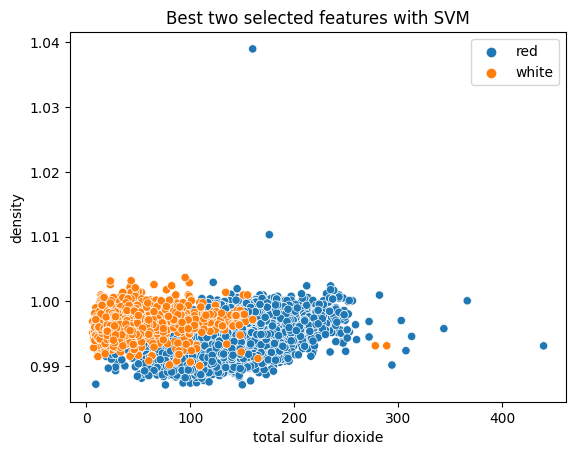

In [42]:
ax = sns.scatterplot(x=wines['total sulfur dioxide'], y=wines['density'], data=wines, hue='type');
ax.set_title('Best two selected features with SVM');
handles, labels  =  ax.get_legend_handles_labels()

ax.legend(handles, ['red', 'white'], loc='upper right');

In [40]:
tic_fwd = time.time()
sfs_forward = SequentialFeatureSelector(
    knn, n_features_to_select=2, direction="forward"
).fit(x_train, y_train)
toc_fwd = time.time()

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")

Features selected by forward sequential selection: ['chlorides' 'total sulfur dioxide']
Done in 0.604s


## Backward Elimination

In [13]:
def rbfs(x_train, x_test, y_train, y_test, model, k_features):
    
#     num_features = x_train.shape[1]
    all_features = x_train.columns.tolist()
    best_scores = []
    best_subset = all_features
    
    init_time = time.time()
    while (len(best_subset) > k_features):
        scores = []
        subsets = []
#         all_features = list(set(all_features) - set(best_subset))
        for feature in best_subset:
            subset = list(set(best_subset) - set([feature]))
#             print(subset)
            score = fit_model(x_train, x_test, y_train, y_test, subset, model)
            scores.append(score)
            subsets.append(subset)

        best_score_index = np.argmax(scores)
        best_scores.append(scores[best_score_index])
        best_subset = subsets[best_score_index]
    
    print("RBFS time:",  
      (time.time() - init_time)*1000, 
      "miliseconds\n")
    return (best_scores, best_subset)

In [14]:
score1, subset1 = rbfs(x_train, x_test, y_train, y_test, knn, 2)
print("Selected features in order: \n", subset)
print("\nSelected features accuracy score: \n", score)

RBFS time: 6946.55704498291 miliseconds

Selected features in order: 
 ['total sulfur dioxide', 'chlorides', 'density', 'sulphates', 'alcohol', 'residual sugar', 'citric acid', 'quality', 'fixed acidity', 'volatile acidity', 'free sulfur dioxide', 'pH']

Selected features accuracy score: 
 [0.9053217821782178, 0.9746287128712872, 0.9820544554455446, 0.9931930693069307, 0.9938118811881188, 0.9956683168316832, 0.9938118811881188, 0.9956683168316832, 0.9956683168316832, 0.9931930693069307, 0.9938118811881188, 0.9907178217821783]


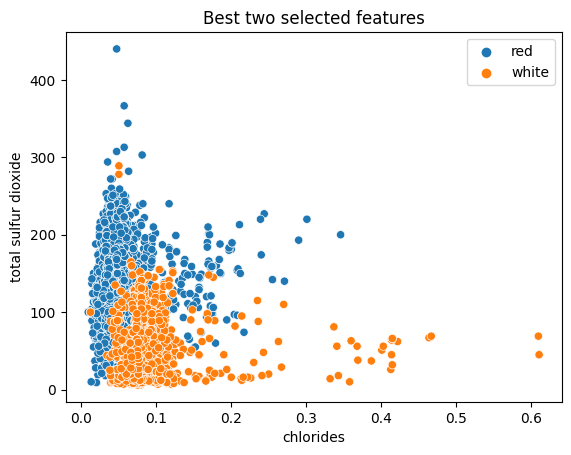

In [15]:
ax = sns.scatterplot(x=subset1[-1], y=subset1[-2], data=wines, hue='type');
ax.set_title('Best two selected features');
handles, labels  =  ax.get_legend_handles_labels()

ax.legend(handles, ['red', 'white'], loc='upper right');

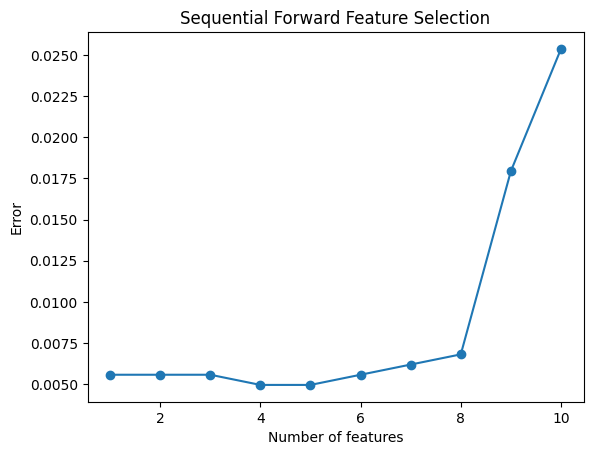

In [17]:
plt.plot(list(range(1,len(x_train.columns.tolist())-1)), 1 - np.array(score1), marker='o');
plt.ylabel('Error')
plt.xlabel('Number of features')
plt.title('Sequential Forward Feature Selection');

In [41]:
tic_bkw = time.time()
selector = RFE(estimator, n_features_to_select=2, step=1).fit(x_train, y_train)
toc_bkw = time.time()

print(
    "Features selected by iterative backward selection: "
    f"{feature_names[selector.support_]}"
)
print(f"Done in {toc_bkw - tic_bkw:.3f}s")

Features selected by iterative backward selection: ['residual sugar' 'density']
Done in 0.338s


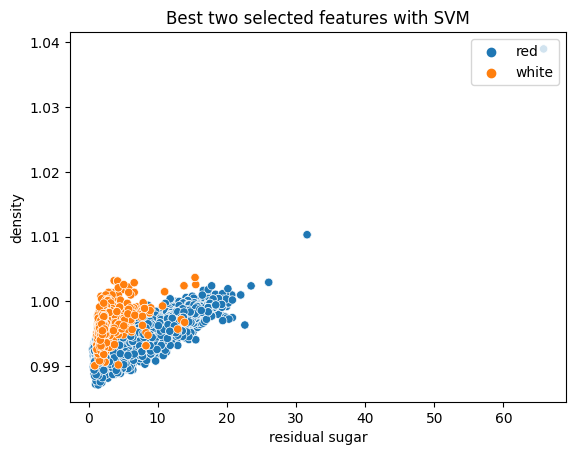

In [43]:
ax = sns.scatterplot(x=wines['residual sugar'], y=wines['density'], data=wines, hue='type');
ax.set_title('Best two selected features with SVM');
handles, labels  =  ax.get_legend_handles_labels()

ax.legend(handles, ['red', 'white'], loc='upper right');